# Data explorations
In this notebook, a first analysis of the data from [Wang (2017)](https://arxiv.org/abs/1705.00648) will be performed. 

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from nltk.tokenize import sent_tokenize, word_tokenize
from plotly import tools
import re

init_notebook_mode(connected=True)

#### Data loading class for interaction with the data

In [2]:
class DataLoader:
    def __init__(self): 
        self.df = {
                    dataset: pd.read_csv('data/liar_dataset/' + dataset + '.tsv', sep='\t', header=None, index_col=0, names=['id', 'label', 'statement', 'subjects', 'speaker', 'speaker_job', 'state', 'party', 'barely_true_count', 'false_count', 'half_true_count', 'mostly_true_count', 'pants_on_fire_count', 'context'])
                    for dataset in ['train', 'test', 'valid']
                  }
        
        self.df['validation'] = self.df['valid']
        self.df.pop('valid', None)
data = DataLoader()

data.df['train']

,label,statement,subjects,speaker,speaker_job,state,party,barely_true_count,false_count,half_true_count,mostly_true_count,pants_on_fire_count,context
id,,,,,,,,,,,,,
2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
2342.json,barely-true,Jim Dunnam has not lived in the district he re...,candidates-biography,republican-party-texas,NaN,Texas,republican,3.0,1.0,1.0,3.0,1.0,a press release.
153.json,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
5602.json,half-true,"However, it took $19.5 million in Oregon Lotte...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website


<hr>
## Testing descriptive statistics
To ensure the dataset has not been adjusted, we need to combine the three datasets and compare some counts with the listings in the research article. The following dataset statistics should be present:

| Dataset statistics             |        || Top-3 Speaker Affiliations |       |
|--------------------------------|--------||----------------------------|-------|
| Training set size              | 10,269 || Democrats                  | 4,150 |
| Validation set size            | 1,284  || Republicans                | 5,687 |
| Testing set size               | 1,283  || None (e.g., FB posts)      | 2,185 |
| Avg. statement length (tokens) | 17.9   |







In [150]:
print({
    'Training set size': len(data.df['train'].label),
    'Validation set size': len(data.df['validation'].label),
    'Testing set size': len(data.df['test'].label),
    'Avg. statement length (tokens)': pd.concat([data.df['train'].statement, data.df['test'].statement, data.df['validation'].statement]).apply(lambda x: len(x.split(' '))).mean(),
})

affil_col = pd.concat([data.df['train'].party, data.df['test'].party, data.df['validation'].party])
print({
    'Democrats': len(list(filter(lambda x: x == 'democrat', affil_col.values))),
    'Republicans': len(list(filter(lambda x: x == 'republican', affil_col.values))),
    'None': len(list(filter(lambda x: x == 'none', affil_col.values))),
})

{'Training set size': 10240, 'Validation set size': 1284, 'Testing set size': 1267, 'Avg. statement length (tokens)': 17.991947463059965}
{'Democrats': 4137, 'Republicans': 5665, 'None': 2181}


In [10]:
labels = ['Training set', 'Validation set', 'Test set']
values = [10240, 1284, 1267]

trace = [go.Pie(labels = labels, values = values, textinfo = 'value')]

layout = go.Layout(
    title = 'Distribution of statements across the train, test and validation sets',
)

fig = go.Figure(data = trace, layout = layout)

iplot(fig)

Although there are minor differences, we can conclude that the dataset from the research article has not been adjusted heavily since release.
<hr>
## Assessing data quality
The next step is whether we need to clean any of the data. As we are only interested in statements, we will check on anomalities in sentence length for this next step.

In [4]:
total_statements = pd.concat([data.df['train'].statement, data.df['test'].statement, data.df['validation'].statement])
sentence_counter = total_statements.apply(lambda x: len(sent_tokenize(x)))
total_statements = pd.concat([total_statements, sentence_counter], axis=1)
total_statements.columns = ['statement', 'sentence_length']

sorted_statements = Counter(total_statements.sentence_length.values)

chart = [go.Pie(
            labels = list(sorted_statements.keys()),
            values = list(sorted_statements.values()),
        )]

iplot(chart)

In [5]:
sorted_statements

Counter({1: 11219,
         2: 1237,
         3: 199,
         4: 98,
         5: 22,
         6: 6,
         19: 1,
         11: 2,
         8: 2,
         9: 1,
         7: 2,
         14: 1,
         10: 1})

The biggest share of statements are just 1 sentence long. However, some are longer. Let's find out why.

In [6]:
total_statements[total_statements['sentence_length'] == total_statements['sentence_length'].max()].statement.values

array(['Hospitals, doctors, MRIs, surgeries and so forth are more extensively used and far more expensive in this country than they are in many other countries.\'\'\thealth-care\tmitt-romney\tFormer governor\tMassachusetts\trepublican\t34\t32\t58\t33\t19\ta Fox News Sunday interview\n9874.json\tbarely-true\tObamacare cuts seniors Medicare.\thealth-care,medicare\ted-gillespie\tRepublican strategist\tWashington, D.C.\trepublican\t2\t3\t2\t2\t1\ta campaign email.\n3072.json\tmostly-true\tThe refusal of many federal employees to fly coach costs taxpayers $146 million annually.\tgovernment-efficiency,transparency\tnewsmax\tMagazine and website\tFlorida\tnone\t0\t0\t0\t1\t0\tan e-mail solicitation\n2436.json\tmostly-true\tFlorida spends more than $300 million a year just on children repeating pre-K through 3rd grade.\teducation\talex-sink\t\tFlorida\tdemocrat\t1\t2\t2\t4\t0\tfigures cites on campaign website\n9721.json\ttrue\tMilwaukee County Sheriff David A. Clarke Jr. advised citizens to p

In [7]:
re.findall(r'\.json%%(mostly-true|true|half-true|false|barely-true|pants-fire)', re.sub(r"\t", "%%", total_statements[total_statements['sentence_length'] == 14].statement.values[0]))

['mostly-true',
 'mostly-true',
 'mostly-true',
 'half-true',
 'mostly-true',
 'true',
 'mostly-true',
 'false',
 'barely-true',
 'barely-true',
 'half-true']

In [8]:
total_statements[total_statements['sentence_length'] == 14].statement.values[0]

'As a state rep, I was considered the fourth-most conservative in the Legislature.\tstates\trick-green\t\t\trepublican\t0\t1\t1\t0\t0\ta speech\n2552.json\tmostly-true\tRand Paul wants us to pay $2,000 just to get Medicare.\thealth-care,medicare,message-machine\tjack-conway\tKentucky Attorney General\tKentucky\tdemocrat\t0\t1\t0\t2\t0\ta campaign commercial\n9353.json\tmostly-true\tSays Hillary Clinton opposed an individual mandate and favored an employer mandate back in 1993.\thealth-care,public-health\tbobby-jindal\tGovernor of Louisiana\tLouisiana\trepublican\t0\t1\t4\t4\t0\tan op-ed for Politico Magazine\n9577.json\tmostly-true\tThere are more than 46 million Americans living in poverty today -- the largest number in 54 years.\tmedicaid,poverty\tkirk-cox\tHouse majority leader\tVirginia\trepublican\t0\t0\t0\t1\t0\ta speech.\n4318.json\thalf-true\tSince I introduced my budget -- first budget -- in March of 2010, weve created 50,000 new private-sector jobs for the people of this stat

As can be seen, there was a fault in the scraping of the data, resulting in multiple statements to be concatenated into one row. By running the following regular expression, these faulty lines should be able to be detected:
```
/\.json\\t(mostly-true|true|half-true|false|barely-true|pants-fire)/g
```
<hr>
## Cleaning data
Applying the abovementioned regex filter on the dataset.

In [9]:
for dataset in data.df.keys():
    data.df[dataset]['mistake_filter'] = data.df[dataset].statement.apply(lambda x: len(re.findall(r'\.json%%(mostly-true|true|half-true|false|barely-true|pants-fire)', re.sub(r"\t", "%%", x))))
    data.df[dataset] = data.df[dataset][data.df[dataset]['mistake_filter'] == 0]
    data.df[dataset].drop(columns = 'mistake_filter', inplace = True)

/Users/martijn/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [10]:
total_statements = pd.concat([data.df['train'].statement, data.df['test'].statement, data.df['validation'].statement])
sentence_counter = total_statements.apply(lambda x: len(sent_tokenize(x)))
total_statements = pd.concat([total_statements, sentence_counter], axis=1)
total_statements.columns = ['statement', 'sentence_length']

sorted_statements = Counter(total_statements.sentence_length.values)
sorted_statements

Counter({1: 11219, 2: 1236, 3: 198, 4: 98, 5: 22, 6: 6, 8: 2, 7: 2, 11: 1})

<hr>
## Analysis of data
To get a better idea of the context of the statements, it might be interesting to look at some statistics surrounding the subjects.

In [29]:
subjects = []

for subject in pd.concat([data.df['train'].subjects, data.df['test'].subjects, data.df['validation'].subjects]).values:
    try:
        subjects.append(subject.split(','))
    except:
        pass

subjects = np.concatenate(subjects)

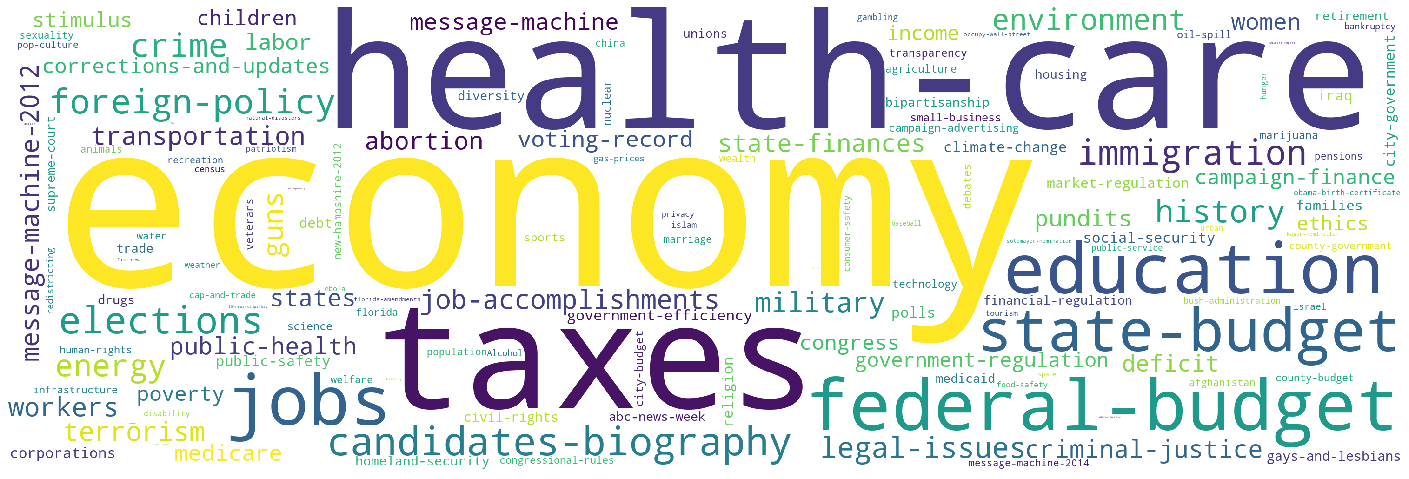

In [30]:
subjects_counter = Counter(subjects)
wordcloud = WordCloud(width = 3000, height = 1000, background_color = 'white').generate_from_frequencies(subjects_counter)

plt.figure(figsize = (25, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [31]:
sorted_subjects = subjects_counter.most_common(len(subjects_counter.keys()))

chart = [go.Bar(
            x = list(map(lambda x: x[0], sorted_subjects)),
            y = list(map(lambda x: x[1], sorted_subjects)),
        )]

iplot(chart)

In [34]:
sorted_parties = Counter(pd.concat([data.df['train'].party, data.df['test'].party, data.df['validation'].party]).values).most_common(len(subjects_counter.keys()))

chart = [go.Bar(
            x = list(map(lambda x: x[0], sorted_parties)),
            y = list(map(lambda x: x[1], sorted_parties)),
        )]

iplot(chart)

In [15]:
total_statements = pd.concat([data.df['train'].statement, data.df['test'].statement, data.df['validation'].statement])
word_counter = total_statements.apply(lambda x: len(word_tokenize(x)))

In [25]:
word_counting = Counter(word_counter).most_common(len(word_counter.keys()))

In [47]:
word_std = word_counter.std()
word_median = word_counter.median()

chart = [go.Bar(
            x = list(map(lambda x: x[0], word_counting)),
            y = list(map(lambda x: x[1], word_counting)),
        )]

iplot({
    'data': chart,
    'layout': {
        'shapes': [
            # Line Vertical
            {
                'type': 'line',
                'x0': word_median,
                'y0': 0,
                'x1': word_median,
                'y1': 747,
                'line': {
                    'color': 'rgb(0,0,0)',
                    'width': 3,
                },
            },
            {
                'type': 'line',
                'x0': word_median - word_std * 2,
                'y0': 0,
                'x1': word_median - word_std * 2,
                'y1': 747,
                'line': {
                    'color': 'rgb(0,0,0)',
                    'width': 3,
                },
            },
            {
                'type': 'line',
                'x0': word_median + word_std * 2,
                'y0': 0,
                'x1': word_median + word_std * 2,
                'y1': 747,
                'line': {
                    'color': 'rgb(0,0,0)',
                    'width': 3,
                },
            }
        ]
    },
})

<hr>

## Recoding the labels

In [28]:
# Recode labels from 6 to 3
def recode(label):
    if label == 'false' or label == 'pants-fire' or label == 'barely-true':
        return 'false'
    elif label == 'true' or label == 'mostly-true':
        return 'true'
    elif label == 'half-true':
        return 'half-true'

In [41]:
old_labels = Counter(pd.concat([data.df['train'].label, data.df['test'].label, data.df['validation'].label]).values)
new_labels = Counter(
        pd.concat([
            data.df['train'].label.apply(lambda label: recode(label)), 
            data.df['test'].label.apply(lambda label: recode(label)), 
            data.df['validation'].label.apply(lambda label: recode(label))
        ]).values)

charts = [
    go.Pie(
        labels = list(old_labels.keys()),
        values = list(old_labels.values()),
        name = 'Old distribution',
        domain = dict(x=[0,0.5]),
        title = 'Old distribution'
    ), 
    go.Pie(
        labels = list(new_labels.keys()),
        values = list(new_labels.values()),
        name = 'New distribution',
        domain=dict(x=[0.5,1.0]),
        title = 'New distribution'
    ),
]

layout = go.Layout(
    title = 'Distribution of statements across the labels before and after recoding',
)

fig = go.Figure(data = charts, layout = layout)

iplot(fig)

In [38]:
go.Pie?